Write a colab numpy only from scratch 3 layer deep neural network for non linear regression . Use proper non linear activation functions and proper number of hidden layer neurons - show the results / loss and epochs training and final output . You will be doing manual backprop and chain rule based gradient propagation

#import the necessary libraries

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
     

#sample data

In [27]:
n_samples = 100
input_dimensions = 3
output_dimensions = 2

np.random.seed(103)
X = np.random.uniform(-1, 1, (n_samples, input_dimensions))
print('Samples values of x:', X[:3])

weights_true = np.array([[5, 1, 2], [1, 2, 3]])
bias_true = np.array([[1], [1]])

y_true = (6 * X ** 2) @ weights_true.T + X @ weights_true.T + bias_true.T

print('Samples values of y:', y_true[:3])
print(f'X: {X.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

Samples values of x: [[-0.13577759 -0.65156947 -0.65811263]
 [ 0.6552645   0.17434252 -0.08129251]
 [ 0.64536952  0.64309622 -0.3857595 ]]
Samples values of y: [[ 6.6509874  10.58789244]
 [17.43090029  4.81999763]
 [20.86064035 11.91475436]]
X: (100, 3), weights: (2, 3), bias: (2, 1), y: (100, 2)


#Plot the 3d data

In [28]:
def plot_3d(title, X, y, y_pred=None):
  X_tsne = TSNE(n_components = 2, random_state=123).fit_transform(X)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_tsne[:, 0], X_tsne[:, 1], y, label='y_true')
  ax.set_title(title)
  if y_pred is not None:
     ax.scatter(X_tsne[:, 0], X_tsne[:, 1], y_pred, label='y_pred', marker = '^')
  plt.legend()
  plt.show()
     


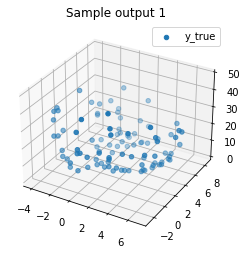

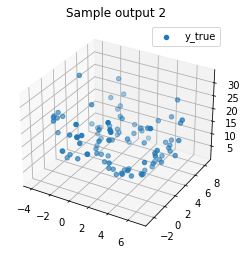

In [29]:
plot_3d('Sample output 1', X, y_true[:,0])
plot_3d('Sample output 2', X, y_true[:,1])

#NeuralNetwork from scratch

In [30]:
#MSE- Mean Squared Error

class MSE:
  def __init__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
  
  def get_error(self):
    n = self.y_true.shape[0]
    return ((self.y_pred - self.y_true) ** 2) / n
  
  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2.0 * (self.y_pred - self.y_true) / n
    return self.gradient


In [31]:
#ReLU 

class Relu:
  def __init__(self):
    self.input = np.array([])

  def forward(self, input):
    self.input = input.copy()
    self.output = np.clip(self.input, 0, None)
    return self.output
  
  # If input is less than 0, derivative is 0. If input is greater than 0, derivative is 1
  def backward(self, upstr_gradient):
    return (self.input > 0) * upstr_gradient
  
  # No update needed to ReLU members
  def update(self, lr):
    return

  def __str__(self):
    return 'ReLu'
     


In [32]:
class Layer:
  def __init__(self, n_input_nodes=1, n_output_nodes=1, activation_func=None):
    # Initialize the layer with the number of input and output nodes
    self.n_input_nodes = n_input_nodes
    self.n_output_nodes = n_output_nodes

    # Initialize the layer with random weights and bias
    self.weights = np.random.rand(n_input_nodes, n_output_nodes)
    self.bias = np.random.rand((1))
    self.X = np.zeros([n_input_nodes])

    # Set the activation function for the layer
    if activation_func == 'relu':
      self.activation_func = Relu()
    else: 
      self.activation_func = None
  
  def forward(self, X):
    # Save the input to the layer
    self.X = X.copy()

    # Calculate the dot product of the inputs with the weights and add the bias
    self.Z = X @ self.weights + self.bias
    
    # Apply the activation function if one is specified
    if self.activation_func == None:
      return self.Z 
    else:
      return self.activation_func.forward(self.Z)

  def backward(self, upstream_gradient):
    # Copy the upstream gradient
    current_upstream_gradient = upstream_gradient.copy()

    # If the layer has an activation function, backpropagate through it first
    if self.activation_func != None:
      current_upstream_gradient = self.activation_func.backward(current_upstream_gradient)
    
    # Compute the gradient of the weights with respect to the loss
    self.dJdW = self.X.T @ current_upstream_gradient
    
    # Compute the gradient of the bias with respect to the loss
    self.dJdb = current_upstream_gradient.sum()

    # Compute the gradient of the input with respect to the loss
    self.dJdX = current_upstream_gradient @ self.weights.T

    # Return the gradient of the input, which serves as the new upstream gradient for the previous layer
    return self.dJdX

  # Update the weights and bias with the learning rate
  def update(self, lr):
    self.weights = self.weights - lr * self.dJdW
    self.bias = self.bias - lr * self.dJdb

  def __str__(self):
    # Print the layer's input, weights, and bias
    return 'Layer: ({},{}) Activation Function: {}\nInputs:\n{} \nWeights:\n{} \nBias:{}'.format(self.n_input_nodes, self.n_output_nodes, self.activation_func, self.X[:2], 
            self.weights, self.bias)


In [33]:
class NeuralNetwork_Model:
  def __init__(self, n_inputs=3, n_hidden=[2], n_outputs=2, activation_func=None):
    self.n_inputs = n_inputs
    self.n_hidden = n_hidden
    self.n_outputs = n_outputs

    # Creating a list of layer sizes
    layers = [self.n_inputs] + self.n_hidden + [self.n_outputs]

    # Creating a list of layers
    self.layers = []
    for i in range(len(layers[:-1])):
      # Not adding the activation function to last layer because it is a regression problem
      if i == len(layers[:-1]) - 1:
        self.layers.append(Layer(layers[i], layers[i + 1], activation_func=None))
      else:
        self.layers.append(Layer(layers[i], layers[i + 1], activation_func))

    # Printing the network architecture
    print('Neural Network Architecture:')
    for i, layer in enumerate(self.layers):
      print('---------------------- Layer {} ----------------------'.format(i))
      print(layer)
    print()

  def forward(self, inputs):
    # Propagating the input through the layers
    current_output = inputs.copy()
    for l in self.layers:
      current_output = l.forward(current_output)
    return current_output

  def backward(self, y_pred, y_true):
    # Starting with the gradient from loss function with respect to prediction
    mse = MSE(y_pred, y_true)
    error = mse.get_error()
    print('MSE: ', mean_squared_error(y_true, y_pred))
    loss_gradient = mse.backward()

    # Propagating the error back through the layers to compute gradients for each layer
    gradient = loss_gradient.copy()
    for layer in reversed(self.layers):
      gradient = layer.backward(gradient)

  def update(self, lr):
    # Updating the weights and biases of the layers with the learning rate
    for layer in self.layers:
      layer.update(lr)

  # Training loop over number of epochs
  def fit(self, X, y_true, epochs, lr):
    for i in range(epochs):
      # Propagating the input through the network and computing gradients
      y_pred = self.forward(X)
      self.backward(y_pred, y_true)
      # Updating the weights and biases with the computed gradients
      self.update(lr)

  def __str__(self):
    # Creating a string representation of the network
    s = [str(layer) for layer in self.layers]
    return '\n'.join(s)


#Hyperparameters

In [34]:
# Number of Iterations
epochs = 200

# Learning rate of the algorithm
lr = 0.01

# Input and output size. i.e 3 and 2 relatively
input = X.shape[1]
output = y_true.shape[1]

print(input)
print(output)
     

3
2


#Training Neural Network with ReLU

In [35]:
model = NeuralNetwork_Model(n_inputs=input, n_hidden=[4, 3], n_outputs=output, activation_func='relu')
model.fit(X, y_true, epochs, lr=0.01)
y_pred = model.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final MSE with ReLU: {}'.format(err))

Neural Network Architecture:
---------------------- Layer 0 ----------------------
Layer: (3,4) Activation Function: ReLu
Inputs:
[0. 0.] 
Weights:
[[0.73984456 0.31728742 0.90930111 0.64862782]
 [0.84316331 0.97946298 0.56520144 0.16470195]
 [0.36879684 0.18150969 0.44907341 0.5266519 ]] 
Bias:[0.64328759]
---------------------- Layer 1 ----------------------
Layer: (4,3) Activation Function: ReLu
Inputs:
[0. 0.] 
Weights:
[[0.63938332 0.12184133 0.11968527]
 [0.54453475 0.27624261 0.18750296]
 [0.40331937 0.83150724 0.63055054]
 [0.91680217 0.78896509 0.08260175]] 
Bias:[0.68583816]
---------------------- Layer 2 ----------------------
Layer: (3,2) Activation Function: None
Inputs:
[0. 0.] 
Weights:
[[0.92366609 0.05140479]
 [0.87261066 0.86227867]
 [0.77439399 0.69150375]] 
Bias:[0.34147931]

MSE:  175.74076090762435
MSE:  127.5693954436387
MSE:  254.85671529620942
MSE:  219.9378596033364
MSE:  165.7328787002794
MSE:  102.57549692908287
MSE:  76.08139567794902
MSE:  74.0831879559230

#Training Neural Network without Relu

In [38]:
model = NeuralNetwork_Model(n_inputs=input, n_hidden=[4, 3], n_outputs=output, activation_func=None)
model.fit(X, y_true, epochs, lr=0.01)
y_pred = model.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final MSE without ReLU: {}'.format(err))
     

Neural Network Architecture:
---------------------- Layer 0 ----------------------
Layer: (3,4) Activation Function: None
Inputs:
[0. 0.] 
Weights:
[[0.96299241 0.6774652  0.99721888 0.96127201]
 [0.24681597 0.00602358 0.55474114 0.4368149 ]
 [0.27137036 0.03666493 0.80906126 0.2082198 ]] 
Bias:[0.45567065]
---------------------- Layer 1 ----------------------
Layer: (4,3) Activation Function: None
Inputs:
[0. 0.] 
Weights:
[[0.1933143  0.75344085 0.19674224]
 [0.97166238 0.014279   0.52967556]
 [0.11162124 0.21444764 0.2490518 ]
 [0.04664    0.36662737 0.79364253]] 
Bias:[0.7489095]
---------------------- Layer 2 ----------------------
Layer: (3,2) Activation Function: None
Inputs:
[0. 0.] 
Weights:
[[0.18038513 0.53132577]
 [0.93022384 0.74029307]
 [0.8943591  0.60876641]] 
Bias:[0.25510534]

MSE:  205.8253812012994
MSE:  83.03738389985199
MSE:  93.71507516077097
MSE:  172.86217730927777
MSE:  294.54455958962546
MSE:  231.46873441109074
MSE:  163.7263656826607
MSE:  124.0614081442849

Conclusion : from the above experiment we can see that how the error is more when ReLU activation is not applied 

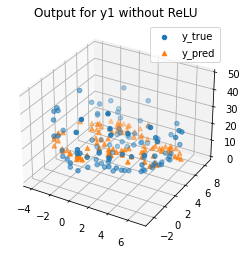

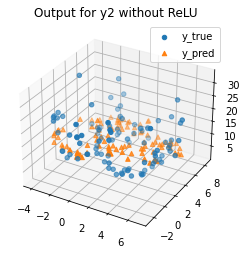

In [39]:
plot_3d('Output for y1 without ReLU', X, y_true[:,0], y_pred[:,0])
plot_3d('Output for y2 without ReLU', X, y_true[:,1], y_pred[:,1])